In [3]:
from __future__ import print_function, division
import os
# import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, utils
from skimage.io import imread_collection
from PIL import Image

In [2]:
!git clone https://github.com/thsant/wgisd.git

Cloning into 'wgisd'...
remote: Enumerating objects: 3400, done.
remote: Total 3400 (delta 0), reused 0 (delta 0), pack-reused 3400
Receiving objects: 100% (3400/3400), 1.33 GiB | 40.39 MiB/s, done.
Resolving deltas: 100% (323/323), done.
Checking out files: 100% (1045/1045), done.


In [4]:
a = 'thsant-wgisd-ab223e5/data/*.jpg'
a

'thsant-wgisd-ab223e5/data/*.jpg'

In [9]:
imgs = imread_collection(a)
imgs[0]

array([[[ 27,  41,  24],
        [ 27,  41,  24],
        [ 27,  41,  24],
        ...,
        [148, 187, 192],
        [154, 185, 190],
        [153, 176, 184]],

       [[ 28,  42,  25],
        [ 27,  41,  24],
        [ 27,  41,  24],
        ...,
        [141, 178, 186],
        [158, 187, 195],
        [159, 182, 190]],

       [[ 28,  42,  27],
        [ 27,  41,  26],
        [ 27,  41,  26],
        ...,
        [140, 174, 184],
        [160, 189, 197],
        [161, 186, 191]],

       ...,

       [[ 90, 118,  77],
        [116, 128,  88],
        [147, 133,  96],
        ...,
        [241, 241, 233],
        [241, 238, 231],
        [233, 230, 223]],

       [[146, 142, 117],
        [129, 113,  88],
        [115,  85,  59],
        ...,
        [241, 241, 233],
        [239, 239, 231],
        [235, 235, 227]],

       [[100,  97,  80],
        [ 75,  64,  44],
        [ 79,  61,  37],
        ...,
        [240, 241, 233],
        [236, 237, 229],
        [239, 239, 231]]

In [3]:
img_dir = 'wgisd/data/*.jpg'
imgs = imread_collection(img_dir)

In [4]:
all_files = os.listdir("wgisd/data")
txt_files = list(filter(lambda x: x[-4:] == '.txt', all_files))

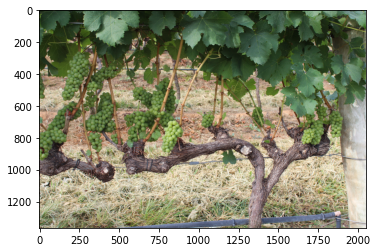

In [4]:
plt.imshow(imgs[0])

In [5]:
annotations = []
for i in range(0, len(txt_files)):
  annotation = np.loadtxt("wgisd/data/" + txt_files[i], dtype=np.float32)
  annotations.append(annotation)

In [50]:
def show_landmarks(image, annotation):
    plt.imshow(image)
    # Comparing x & y values of each bounding box by storing them in separate list
    x = list(map(lambda x: 225 * float(x), annotation[:,1]))
    y = list(map(lambda x: 150 * float(x), annotation[:,2]))
    plt.scatter(x, y, s=10, marker='o', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

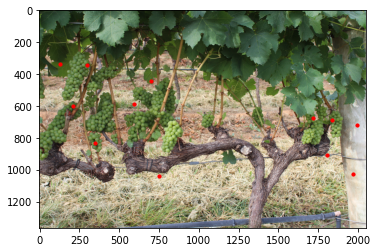

In [7]:
plt.figure()
show_landmarks(imgs[0], annotations[0])
plt.show()

# Creating a Dataset class 

In [46]:
class GrapesDataset(Dataset):
  def __init__(self, root_dir):
    data_transforms = transforms.Compose([transforms.Resize(225),transforms.ToTensor()])
    img_dir = root_dir + '/*.jpg'
    all_files = os.listdir(root_dir)
    txt_files = list(filter(lambda x: x[-4:] == '.txt', all_files))
    annotations = []
    orgImgs = imread_collection(img_dir)
    for i in range(0, len(txt_files)):
      annotations.append(np.loadtxt(root_dir + "/" + txt_files[i], dtype=np.float32))
    images_resized = list(map(lambda x: transform.resize(x, (150, 225),anti_aliasing=True), orgImgs))
    
    self.images = images_resized
    self.root_dir = root_dir
    self.annotations = annotations

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
        
    sample = {'image': self.images[idx], 'annotations': self.annotations[idx]}
    return sample

In [47]:
grapesDS = GrapesDataset("wgisd/data")

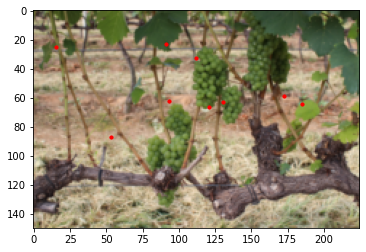

In [54]:
plt.figure()
sample = grapesDS[1]
show_landmarks(sample["image"], sample["annotations"])
plt.show()

# Creating Batches using Dataloader

In [94]:
dataloader = DataLoader(grapesDS, batch_size=5, collate_fn=lambda x: x)

In [124]:
def showBatchAnnotations(sample_batched):
  images_batch, annotations_batch = [sample_batched[i]['image'] for i in range(0,len(sample_batched))], [sample_batched[i]['annotations'] for i in range(0,len(sample_batched))]
  batch_size = len(images_batch)
  
  for i in range(batch_size):
    show_landmarks(images_batch[i], annotations_batch[i])
      
  plt.title('Batch from dataloader')

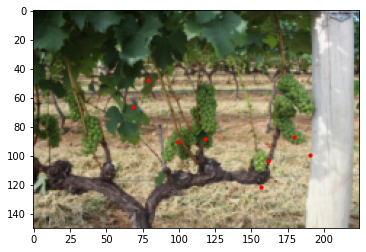

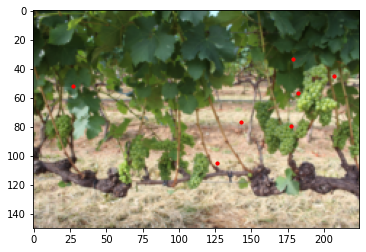

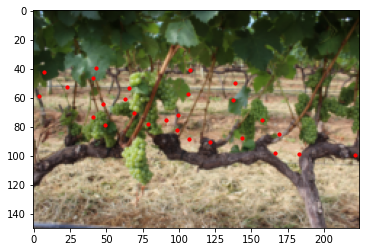

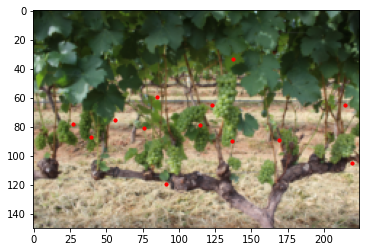

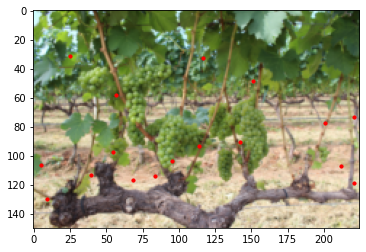

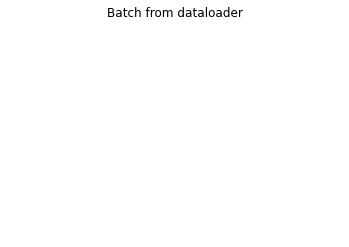

In [125]:
for i_batch, sample_batched in enumerate(dataloader):
  # observe 1st batch and stop.
  if i_batch == 1:
      plt.figure()
      showBatchAnnotations(sample_batched)
      plt.axis('off')
      plt.ioff()
      plt.show()
      break

# Iterating 10 times through Dataloader and saving the batches 

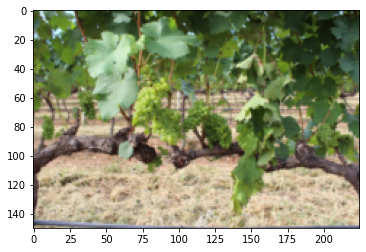

In [150]:
if not os.path.exists('output_batches'):
  os.makedirs('output_batches')

for i in range(0, 10):
  dataloader = DataLoader(grapesDS, batch_size=5, collate_fn=lambda x: x)

  if not os.path.exists('output_batches/batch_'+str(i+1)):
    os.makedirs('output_batches/batch_'+str(i+1))

  for i_batch, sample_batched in enumerate(dataloader):
    # observe 1st batch and stop.
    if i_batch == 1:
        images_batch, annotations_batch = [sample_batched[i]['image'] for i in range(0,len(sample_batched))], [sample_batched[i]['annotations'] for i in range(0,len(sample_batched))]
        size = len(images_batch)
        for j in range(size):
          plt.imshow(images_batch[j])
          plt.savefig("output_batches/batch_"+str(i+1) + "/image"+str(j)+".jpg")
          np.savetxt("output_batches/batch_"+str(i+1) + "/annotation"+str(j)+".txt", annotations_batch[j])
        break